<img src=https://audiovisuales.icesi.edu.co/assets/custom/images/ICESI_logo_prin_descriptor_RGB_POSITIVO_0924.jpg width=200>

  ### Maestría en Inteligencia Artificial
  ### Proyecto de Innovación

## **1. Carga de paquetes**

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            precision_score, recall_score, f1_score, roc_curve, auc)
from tensorflow.keras.metrics import AUC, Precision, Recall

## **2. Carga de datos**

Se espera encontrar las imágenes en la carpeta base, conteniendo las diferentes bases de datos de imágenes en una carpeta cada una: ORIGA, REFUGE y G1020.

Si los datos se encuentran en Google Drive / Google Colab (descomentar las siguientes líneas):

In [2]:
# # Montar Drive
# Si estás usando Google Colab, descomenta las siguientes líneas para montar tu Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Rutas base
# base_path = "/content/drive/MyDrive/Colab Notebooks/Glaucoma"

Si los datos se encuentran en local (descomentar la línea siguiente):

In [4]:
# Rutas base
base_path = "./datos/"

In [19]:

# Ruta para los datasets (ORIGA)
origa_path = os.path.join(base_path, "ORIGA")
origa_csv_path = os.path.join(origa_path, "origa_info.csv")
origa_images_path = os.path.join(origa_path, "Images")

# Ruta para los datasets (G1020)
g1020_path = os.path.join(base_path, "G1020")
g1020_csv_path = os.path.join(g1020_path, "G1020.csv")
g1020_images_path = os.path.join(g1020_path, "Images")

In [22]:
df_origa = pd.read_csv(origa_csv_path)
df_origa['Glaucoma'] = df_origa['Label'].astype(str)

In [23]:
df_g1020 = pd.read_csv(g1020_csv_path)
df_g1020['Glaucoma'] = df_g1020['binaryLabels'].astype(str)
df_g1020['Image'] = df_g1020['imageID']

In [26]:
df_origa['Source'] = 'ORIGA'
df_g1020['Source'] = 'G1020'

# Filtrar columnas
df_glaucoma = pd.concat([df_origa, df_g1020], ignore_index=True)
#df_glaucoma = pd.concat([df_origa], ignore_index=True)

# Aplicar la ruta correcta
def get_image_path(row):
    if row['Source'] == 'ORIGA':
        return os.path.join(origa_images_path, row['Image'])
    elif row['Source'] == 'G1020':
        return os.path.join(g1020_images_path, row['Image'])
    else:
        return None
    
# Crear columna 'Path'
df_glaucoma['Path'] = df_glaucoma.apply(get_image_path, axis=1)

conteo = df_glaucoma.groupby('Source').size().reset_index(name='Cantidad')
print(conteo)

  Source  Cantidad
0  G1020      1020
1  ORIGA       650


Partimos train y test

In [27]:
df_train, df_test = train_test_split(df_glaucoma, test_size=0.15, random_state=42, stratify=df_glaucoma['Glaucoma'])

In [28]:
print("Distribucion en entrenamiento:")
print(df_train['Glaucoma'].value_counts(normalize=True))

print("Distribucion en test:")
print(df_test['Glaucoma'].value_counts(normalize=True))

Distribucion en entrenamiento:
Glaucoma
0    0.72234
1    0.27766
Name: proportion, dtype: float64
Distribucion en test:
Glaucoma
0    0.721116
1    0.278884
Name: proportion, dtype: float64


## **3. Parametros para el modelamiento**


Configuración de parámetros para DA y VGG16

In [29]:
width_shape = 224
height_shape = 224
num_classes = 2
epochs = 30
batch_size = 8

Aplicamos técnica de Data Augmentation con el fin de obtener más muestras y que el modelo no presente overfitting.
Acá se puede ver cómo se generan diferentes imágenes a partir de una sola, aplicando modificaciones en este caso como rotación, giros horizontales y verticales.


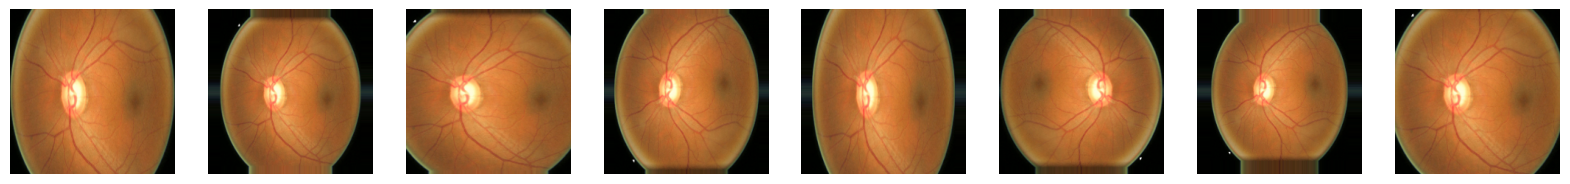

In [30]:
ruta_imagen = df_glaucoma['Path'].iloc[0]

# Cargar imagen, convertir a array y expandir dimensiones para simular batch
img = load_img(ruta_imagen, target_size=(width_shape, height_shape))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # shape (1, 224, 224, 3)

# Generador de visualización
vis_datagen = ImageDataGenerator(
    # rotation_range=90,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Mostrar imágenes aumentadas
plt.figure(figsize=(20,4))
i = 0
for batch in vis_datagen.flow(x, batch_size=1):
    plt.subplot(1, 8, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    i += 1
    if i >= 8:
        break
plt.show()

Generador de imágenes (entrenamiento y test)

In [31]:
train_datagen = ImageDataGenerator(
    # rotation_range=90,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='Path',
    y_col='Glaucoma',
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='Path',
    y_col='Glaucoma',
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

n_train = train_generator.samples
n_test = test_generator.samples

Found 1419 validated image filenames belonging to 2 classes.
Found 251 validated image filenames belonging to 2 classes.


Se identificó un problema de desbalanceo de clases, es decir, un mayor número de observaciones negativas que positivas lo cual afectaría al entrenamiento, por lo que se calcularon los pesos respectivos para cada clase, de tal forma, que se le da más prioridad al momento en el entrenamiento a la clase minoritaria.

In [32]:
classes = np.unique(df_train['Glaucoma'])

# Calcular pesos automáticos
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=df_train['Glaucoma']
)

# Convertir a diccionario
class_weights = dict(zip(classes, class_weights))

print("Pesos por clase:", class_weights)

Pesos por clase: {'0': np.float64(0.6921951219512195), '1': np.float64(1.8007614213197969)}


## **4. Entrenamiento de modelo VGG16**

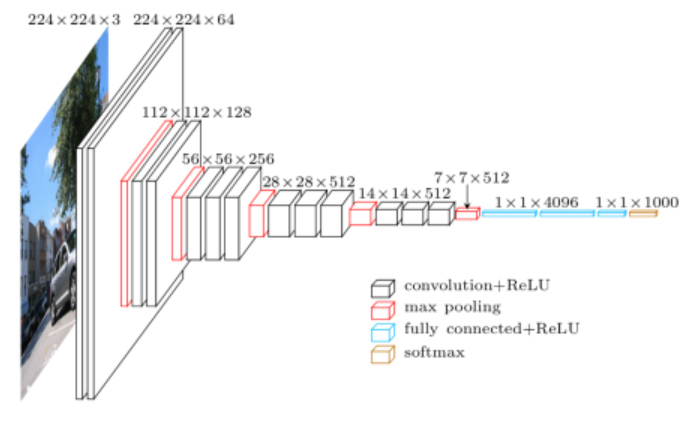

Configuración del modelo personalizando las capas de salida para ajustarlo a nuestro problema de clasificación binaria.

In [33]:
# Número de muestras
nb_train_samples = n_train
nb_validation_samples = n_test

# Cargar la base de VGG16 sin las capas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas de la base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas para la clasificación
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predicciones = Dense(1, activation='sigmoid')(x)

# Definir el modelo completo
vgg16_model = Model(inputs=base_model.input, outputs=predicciones)

# Compilar el modelo
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001),
               loss='binary_crossentropy',
               metrics=['binary_accuracy',AUC(),Precision(), Recall()])
vgg16_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Agregamos un early stop con el fin de que el entrenamiento se detenga cuando deje de ver mejoras en las metricas del modelo

In [34]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True)


In [35]:
# Entrenamiento del modelo
model_history = vgg16_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_steps=nb_validation_samples // batch_size,
    class_weight=class_weights,
    callbacks=[early_stop]
)

/Users/gome33773/Documents/MIAA-ICESI-ProyectoIA/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 103s 578ms/step - auc: 0.5216 - binary_accuracy: 0.6133 - loss: 4.5641 - precision: 0.3013 - recall: 0.3021 - val_auc: 0.5790 - val_binary_accuracy: 0.6976 - val_loss: 0.6611 - val_precision: 0.3929 - val_recall: 0.1594
Epoch 2/30
  1/177 ━━━━━━━━━━━━━━━━━━━━ 1:24 478ms/step - auc: 0.8667 - binary_accuracy: 0.6250 - loss: 0.6818 - precision: 0.0000e+00 - recall: 0.0000e+00

/Users/gome33773/Documents/MIAA-ICESI-ProyectoIA/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


177/177 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - auc: 0.8667 - binary_accuracy: 0.6250 - loss: 0.6818 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5761 - val_binary_accuracy: 0.6935 - val_loss: 0.6531 - val_precision: 0.3571 - val_recall: 0.1471
Epoch 3/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 99s 556ms/step - auc: 0.5461 - binary_accuracy: 0.6708 - loss: 0.7843 - precision: 0.3504 - recall: 0.1847 - val_auc: 0.5510 - val_binary_accuracy: 0.7097 - val_loss: 0.6111 - val_precision: 0.3333 - val_recall: 0.0435
Epoch 4/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - auc: 0.9333 - binary_accuracy: 0.7500 - loss: 0.4561 - precision: 1.0000 - recall: 0.3333 - val_auc: 0.5541 - val_binary_accuracy: 0.7056 - val_loss: 0.6128 - val_precision: 0.3333 - val_recall: 0.0429
Epoch 5/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 97s 547ms/step - auc: 0.5484 - binary_accuracy: 0.7038 - loss: 0.6602 - precision: 0.3595 - recall: 0.0946 - val_auc: 0.5558 - val_binary_accuracy: 0.7218 - val_loss: 0.5987 - val_precisio

Gráficas de entrenamiento y validación (accuracy - loss)

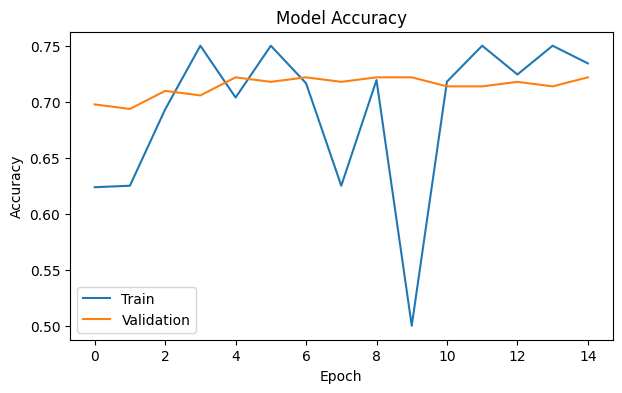

In [36]:
plt.figure(figsize=(7,4))
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

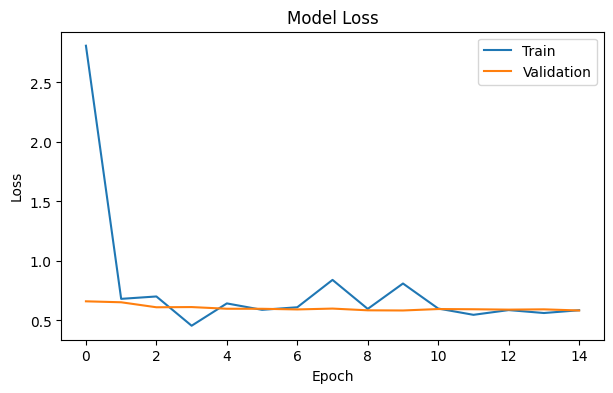

In [37]:
plt.figure(figsize=(7,4))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Acá se puede observar el tratamiento de las imágenes en cada convolución, creando filtros donde detecta formas básicas y complejas como bordes, texturas y formas

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


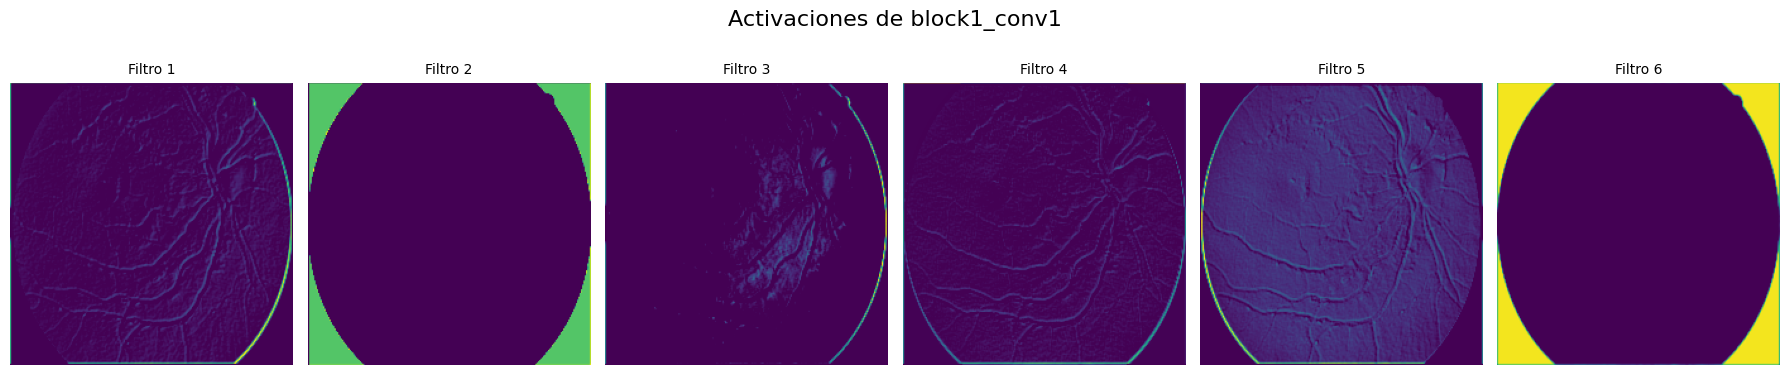

In [39]:
# 1. Cargar imagen aleatoria
img_path = df_train['Path'].iloc[0]
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# 2. Modelo intermedio
layer_name = 'block1_conv1'
# layer_name = 'block2_conv2'
# layer_name = 'block3_conv3'
# layer_name = 'block5_conv3'
intermediate_layer_model = Model(inputs=vgg16_model.input,
                                 outputs=vgg16_model.get_layer(layer_name).output)

# 3. Activaciones
feature_maps = intermediate_layer_model.predict(img_array)

# 4. Visualización en una sola fila
num_filters = 6
plt.figure(figsize=(3 * num_filters, 4))  # Ajusta el tamaño horizontal dinámicamente

for i in range(num_filters):
    plt.subplot(1, num_filters, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filtro {i+1}', fontsize=10)

plt.suptitle(f'Activaciones de {layer_name}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # deja espacio para el título
plt.show()


Encontramos el mejor umbral para la clasificación de las muestras


In [53]:
from sklearn.metrics import balanced_accuracy_score
# Suavizar las probabilidades y etiquetas
y_proba = vgg16_model.predict(test_generator).reshape(-1)
y_true = test_generator.classes

# Buscar el mejor threshold
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_true, y_proba>th) for th in ths])]
print(f'Mejor Threshold Encontrado: {best_th}')
print(f'F1 Score con ese Threshold: {f1_score(y_true, y_proba > best_th)}')

# Aplicar mejor threshold
y_pred = (y_proba > best_th).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step
Mejor Threshold Encontrado: 0.2912912912912913
F1 Score con ese Threshold: 0.4701195219123506


Reporte de clasificación y Accuracy

In [54]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Reporte de clasificación:\n", classification_report(y_true, y_pred))

Accuracy: 0.4701195219123506
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      0.33      0.47       181
           1       0.33      0.84      0.47        70

    accuracy                           0.47       251
   macro avg       0.58      0.58      0.47       251
weighted avg       0.70      0.47      0.47       251



Matriz de Confusión

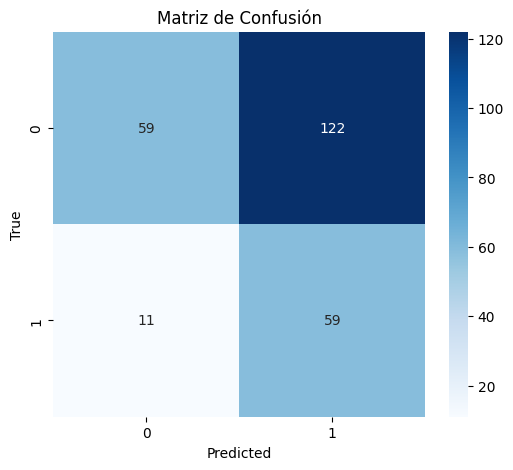

In [55]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

Curva ROC

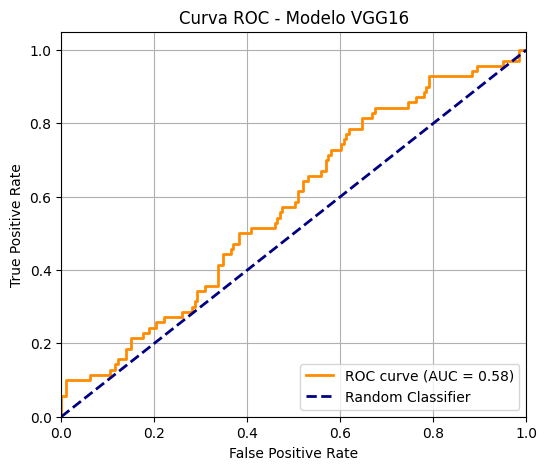

In [56]:
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo VGG16')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
